In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, LeaveOneGroupOut, ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

In [ ]:
def plot_clusters(X, y, title):
    plt.figure(figsize=(10, 6))
    palette = sns.color_palette("hsv", len(np.unique(y)))
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, legend='full', palette=palette, s=60, alpha=0.8)
    plt.title(title)
    plt.show()

def remove_spaces_from_columns(df):
    df.columns = df.columns.str.replace(' ', '', regex=False)
    return df

In [ ]:
## UMAP on 7 sec no overlap periods
## includes biosignals
## 0: no activity (baseline, clean baseline, driving, lunch, working)
## 1: activity (walking, stairs, soccer, cycling)

ppg_dataframes = {}
for i in np.arange(1, 16):
    name = f"data{i}"
    acc = pd.read_csv(f"HAR/ppg+dalia/data/PPG_FieldStudy/S{i}/S{i}_E4/ACC_specific_windowed_features.csv")
    hr = pd.read_csv(f"HAR/ppg+dalia/data/PPG_FieldStudy/S{i}/S{i}_E4/HR_specific_windowed_features.csv")
    bvp = pd.read_csv(f"HAR/ppg+dalia/data/PPG_FieldStudy/S{i}/S{i}_E4/BVP_specific_windowed_features.csv")
    acc['start_time'] = pd.to_datetime(acc['start_time'])
    hr['start_time'] = pd.to_datetime(hr['start_time'])
    bvp['start_time'] = pd.to_datetime(bvp['start_time'])
    acc['end_time'] = pd.to_datetime(acc['end_time'])
    hr['end_time'] = pd.to_datetime(hr['end_time'])
    bvp['end_time'] = pd.to_datetime(bvp['end_time'])

    common_columns = ['start_time', 'end_time', 'activity']
    data = acc.merge(hr, on=common_columns, how='inner').merge(bvp, on=common_columns, how='inner')
    allFeatures  = [col for col in data.columns if col not in ["start_time", "end_time"]]
    data = data[allFeatures]
    data = data[~data['activity'].isin([0])]
    data.loc[data['activity'].isin([2, 7, 8, 9]), 'activity'] = 0
    data.loc[data['activity'].isin([3, 4, 5, 6]), 'activity'] = 1
    ppg_dataframes[name] = data

bigideas_dataframes = {}
for i in np.arange(1, 17):
    if i < 10:
        name = f"data{i}"
        acc = pd.read_csv(f"BigIdeas/00{i}/ACC_simple_windowed.csv")
        hr = pd.read_csv(f"BigIdeas/00{i}/HR_simple_windowed.csv")
        bvp = pd.read_csv(f"BigIdeas/00{i}/BVP_simple_windowed.csv")
    if i > 9:
        name = f"data{i}"
        acc = pd.read_csv(f"BigIdeas/0{i}/ACC_simple_windowed.csv")
        hr = pd.read_csv(f"BigIdeas/0{i}/HR_simple_windowed.csv")
        bvp = pd.read_csv(f"BigIdeas/0{i}/BVP_simple_windowed.csv")
    acc['start_time'] = pd.to_datetime(acc['start_time'])
    hr['start_time'] = pd.to_datetime(hr['start_time'])
    bvp['start_time'] = pd.to_datetime(bvp['start_time'])
    acc['end_time'] = pd.to_datetime(acc['end_time'])
    hr['end_time'] = pd.to_datetime(hr['end_time'])
    bvp['end_time'] = pd.to_datetime(bvp['end_time'])

    common_columns = ['start_time', 'end_time']
    data = acc.merge(hr, on=common_columns, how='inner').merge(bvp, on=common_columns, how='inner')
    allFeatures  = [col for col in data.columns if col not in ["start_time", "end_time"]]
    data = data[allFeatures]
    data.columns = data.columns.str.replace(' ', '', regex=False)
    bigideas_dataframes[name] = data

# Create indices for splitting back the combined data
ppg_indices = list(range(len(pd.concat(ppg_dataframes.values(), ignore_index=True))))
bigideas_indices = list(range(len(pd.concat(bigideas_dataframes.values(), ignore_index=True))))

# Combine all data into a single dataframe for UMAP
combined_df = pd.concat([pd.concat(ppg_dataframes.values(), ignore_index=True),
                         pd.concat(bigideas_dataframes.values(), ignore_index=True)], ignore_index=True)
numerical_cols = [col for col in combined_df.columns if col != 'activity']
scaled_data = StandardScaler().fit_transform(combined_df[numerical_cols])

# Compute UMAP
umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=3)
X_umap = umap_reducer.fit_transform(scaled_data)
umap_df = pd.DataFrame(data=X_umap, columns=[f'UMAP{i}' for i in np.arange(1, 4)])

# Separate the data back into ppg_dataframes and bigideas_dataframes
ppg_df_umap = umap_df.iloc[ppg_indices].reset_index(drop=True)
bigideas_df_umap = umap_df.iloc[bigideas_indices].reset_index(drop=True)

# Add the activity column back to ppg_df_umap
ppg_df_umap['activity'] = combined_df.iloc[ppg_indices]['activity'].reset_index(drop=True)

# Update the original dictionaries with the UMAP data
start_idx = 0
for key, df in ppg_dataframes.items():
    end_idx = start_idx + len(df)
    ppg_dataframes[key] = ppg_df_umap.iloc[start_idx:end_idx].reset_index(drop=True)
    start_idx = end_idx

start_idx = 0
for key, df in bigideas_dataframes.items():
    end_idx = start_idx + len(df)
    bigideas_dataframes[key] = bigideas_df_umap.iloc[start_idx:end_idx].reset_index(drop=True)
    start_idx = end_idx

In [ ]:
import pandas as pd
import numpy as np

def read_and_process_ppg_data():
    ppg_dataframes = {}
    for i in np.arange(1, 16):
        name = f"data{i}"
        acc = pd.read_csv(f"HAR/ppg+dalia/data/PPG_FieldStudy/S{i}/S{i}_E4/ACC_specific_windowed_features.csv")
        hr = pd.read_csv(f"HAR/ppg+dalia/data/PPG_FieldStudy/S{i}/S{i}_E4/HR_specific_windowed_features.csv")
        bvp = pd.read_csv(f"HAR/ppg+dalia/data/PPG_FieldStudy/S{i}/S{i}_E4/BVP_specific_windowed_features.csv")

        acc['start_time'] = pd.to_datetime(acc['start_time'])
        hr['start_time'] = pd.to_datetime(hr['start_time'])
        bvp['start_time'] = pd.to_datetime(bvp['start_time'])
        acc['end_time'] = pd.to_datetime(acc['end_time'])
        hr['end_time'] = pd.to_datetime(hr['end_time'])
        bvp['end_time'] = pd.to_datetime(bvp['end_time'])

        common_columns = ['start_time', 'end_time', 'activity']
        data = acc.merge(hr, on=common_columns, how='inner').merge(bvp, on=common_columns, how='inner')

        all_features = [col for col in data.columns if col not in ["start_time", "end_time"]]
        data = data[all_features]
        data = data[~data['activity'].isin([0])]
        data.loc[data['activity'].isin([2, 7, 8, 9]), 'activity'] = 0
        data.loc[data['activity'].isin([3, 4, 5, 6]), 'activity'] = 1
        ppg_dataframes[name] = data
    return ppg_dataframes

def read_and_process_bigideas_data():
    bigideas_dataframes = {}
    for i in np.arange(1, 17):
        name = f"data{i}"
        if i < 10:
            acc = pd.read_csv(f"BigIdeas/00{i}/ACC_simple_windowed.csv")
            hr = pd.read_csv(f"BigIdeas/00{i}/HR_simple_windowed.csv")
            bvp = pd.read_csv(f"BigIdeas/00{i}/BVP_simple_windowed.csv")
        else:
            acc = pd.read_csv(f"BigIdeas/0{i}/ACC_simple_windowed.csv")
            hr = pd.read_csv(f"BigIdeas/0{i}/HR_simple_windowed.csv")
            bvp = pd.read_csv(f"BigIdeas/0{i}/BVP_simple_windowed.csv")

        acc['start_time'] = pd.to_datetime(acc['start_time'])
        hr['start_time'] = pd.to_datetime(hr['start_time'])
        bvp['start_time'] = pd.to_datetime(bvp['start_time'])
        acc['end_time'] = pd.to_datetime(acc['end_time'])
        hr['end_time'] = pd.to_datetime(hr['end_time'])
        bvp['end_time'] = pd.to_datetime(bvp['end_time'])

        common_columns = ['start_time', 'end_time']
        data = acc.merge(hr, on=common_columns, how='inner').merge(bvp, on=common_columns, how='inner')

        all_features = [col for col in data.columns if col not in ["start_time", "end_time"]]
        data = data[all_features]
        data.columns = data.columns.str.strip()
        bigideas_dataframes[name] = data
    return bigideas_dataframes

def standardize_columns(dataframes, reference_columns):
    for key in dataframes:
        # Ensure the dataframe has the same columns in the same order as the reference columns
        dataframes[key] = dataframes[key].reindex(columns=reference_columns)
    return dataframes

def combine_dataframes(ppg_dataframes, bigideas_dataframes):
    # Get the reference columns from one of the PPG dataframes
    reference_columns = ppg_dataframes['data1'].columns.tolist()

    # Standardize the columns in all dataframes
    ppg_dataframes = standardize_columns(ppg_dataframes, reference_columns)
    bigideas_dataframes = standardize_columns(bigideas_dataframes, reference_columns)

    # Combine all data into a single dataframe for UMAP
    ppg_combined_df = pd.concat(ppg_dataframes.values(), ignore_index=True)
    bigideas_combined_df = pd.concat(bigideas_dataframes.values(), ignore_index=True)

    # Check for NaNs before concatenation
    print(f"NaNs in PPG DataFrame: {ppg_combined_df.isna().sum().sum()}")
    print(f"NaNs in BigIdeas DataFrame: {bigideas_combined_df.isna().sum().sum()}")

    combined_df = pd.concat([ppg_combined_df, bigideas_combined_df], ignore_index=True)

    # Check for NaNs after concatenation
    print(f"NaNs in Combined DataFrame: {combined_df.isna().sum().sum()}")

    # Drop rows with NaNs
    combined_df.dropna(inplace=True)
    return combined_df

ppg_dataframes = read_and_process_ppg_data()
bigideas_dataframes = read_and_process_bigideas_data()
combined_df = combine_dataframes(ppg_dataframes, bigideas_dataframes)

print(f"Shape of Combined DataFrame: {combined_df.shape}")

/tmp/ipykernel_1239167/3472311664.py:44: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  hr['start_time'] = pd.to_datetime(hr['start_time'])
/tmp/ipykernel_1239167/3472311664.py:47: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  hr['end_time'] = pd.to_datetime(hr['end_time'])


NaNs in PPG DataFrame: 0
NaNs in BigIdeas DataFrame: 0
NaNs in Combined DataFrame: 0
Shape of Combined DataFrame: (14185, 71)


In [ ]:
def check_column_consistency(ppg_dataframes, bigideas_dataframes):
    # Check if all PPG dataframes have the same columns
    ppg_columns = [set(df.columns) for df in ppg_dataframes.values()]
    ppg_same_columns = all(cols == ppg_columns[0] for cols in ppg_columns)

    # Check if all BigIdeas dataframes have the same columns and print those that don't
    bigideas_columns = []
    bigideas_keys = []
    for key, df in bigideas_dataframes.items():
        if key not in ['data1', 'data15', 'data16']:
            bigideas_columns.append(set(df.columns))
            bigideas_keys.append(key)

    bigideas_same_columns = True
    different_columns = []

    for name, cols in zip(bigideas_keys, bigideas_columns):
        if cols != bigideas_columns[0]:
            bigideas_same_columns = False
            different_columns.append(name)

    if not bigideas_same_columns:
        print("BigIdeas dataframes with different columns:")
        for name in different_columns:
            print(name)

    # Check if PPG and BigIdeas dataframes have the same columns
    ppg_column_set = ppg_columns[0]
    bigideas_column_set = bigideas_columns[0] if bigideas_columns else set()
    same_columns_across_both = ppg_column_set == bigideas_column_set

    # Print column names of PPG and BigIdeas dataframes
    print("PPG Columns:")
    print(sorted(ppg_column_set))
    print("\nBigIdeas Columns:")
    print(sorted(bigideas_column_set))

    # List columns that are not the same across both datasets
    ppg_not_in_bigideas = ppg_column_set - bigideas_column_set
    bigideas_not_in_ppg = bigideas_column_set - ppg_column_set

    print("\nColumns in PPG but not in BigIdeas:")
    print(sorted(ppg_not_in_bigideas))
    print("\nColumns in BigIdeas but not in PPG:")
    print(sorted(bigideas_not_in_ppg))

    return ppg_same_columns, bigideas_same_columns, same_columns_across_both


ppg_dataframes = {}
for i in np.arange(1, 16):
    name = f"data{i}"
    acc = pd.read_csv(f"HAR/ppg+dalia/data/PPG_FieldStudy/S{i}/S{i}_E4/ACC_specific_windowed_features.csv")
    hr = pd.read_csv(f"HAR/ppg+dalia/data/PPG_FieldStudy/S{i}/S{i}_E4/HR_specific_windowed_features.csv")
    bvp = pd.read_csv(f"HAR/ppg+dalia/data/PPG_FieldStudy/S{i}/S{i}_E4/BVP_specific_windowed_features.csv")
    acc['start_time'] = pd.to_datetime(acc['start_time'])
    hr['start_time'] = pd.to_datetime(hr['start_time'])
    bvp['start_time'] = pd.to_datetime(bvp['start_time'])
    acc['end_time'] = pd.to_datetime(acc['end_time'])
    hr['end_time'] = pd.to_datetime(hr['end_time'])
    bvp['end_time'] = pd.to_datetime(bvp['end_time'])

    common_columns = ['start_time', 'end_time', 'activity']
    data = acc.merge(hr, on=common_columns, how='inner').merge(bvp, on=common_columns, how='inner')
    allFeatures  = [col for col in data.columns if col not in ["start_time", "end_time"]]
    data = data[allFeatures]
    data = data[~data['activity'].isin([0])]
    data.loc[data['activity'].isin([2, 7, 8, 9]), 'activity'] = 0
    data.loc[data['activity'].isin([3, 4, 5, 6]), 'activity'] = 1
    ppg_dataframes[name] = data

bigideas_dataframes = {}
for i in np.arange(1, 17):
    if i < 10:
        name = f"data{i}"
        acc = pd.read_csv(f"BigIdeas/00{i}/ACC_simple_windowed.csv")
        hr = pd.read_csv(f"BigIdeas/00{i}/HR_simple_windowed.csv")
        bvp = pd.read_csv(f"BigIdeas/00{i}/BVP_simple_windowed.csv")
    if i > 9:
        name = f"data{i}"
        acc = pd.read_csv(f"BigIdeas/0{i}/ACC_simple_windowed.csv")
        hr = pd.read_csv(f"BigIdeas/0{i}/HR_simple_windowed.csv")
        bvp = pd.read_csv(f"BigIdeas/0{i}/BVP_simple_windowed.csv")
    acc['start_time'] = pd.to_datetime(acc['start_time'])
    hr['start_time'] = pd.to_datetime(hr['start_time'])
    bvp['start_time'] = pd.to_datetime(bvp['start_time'])
    acc['end_time'] = pd.to_datetime(acc['end_time'])
    hr['end_time'] = pd.to_datetime(hr['end_time'])
    bvp['end_time'] = pd.to_datetime(bvp['end_time'])

    common_columns = ['start_time', 'end_time']
    data = acc.merge(hr, on=common_columns, how='inner').merge(bvp, on=common_columns, how='inner')
    allFeatures  = [col for col in data.columns if col not in ["start_time", "end_time"]]
    data = data[allFeatures]
    data.columns = data.columns.str.strip()
    bigideas_dataframes[name] = data


ppg_same_columns, bigideas_same_columns, same_columns_across_both = check_column_consistency(ppg_dataframes, bigideas_dataframes)

print(f"All PPG dataframes have the same columns: {ppg_same_columns}")
print(f"All BigIdeas dataframes have the same columns: {bigideas_same_columns}")
print(f"PPG and BigIdeas dataframes have the same columns: {same_columns_across_both}")


/tmp/ipykernel_1239167/1848863101.py:85: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  hr['start_time'] = pd.to_datetime(hr['start_time'])
/tmp/ipykernel_1239167/1848863101.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  hr['end_time'] = pd.to_datetime(hr['end_time'])


PPG Columns:
['acc_x_max', 'acc_x_mean', 'acc_x_meancross', 'acc_x_median', 'acc_x_min', 'acc_x_std', 'acc_x_zcross', 'acc_y_max', 'acc_y_mean', 'acc_y_meancross', 'acc_y_median', 'acc_y_min', 'acc_y_std', 'acc_y_zcross', 'acc_z_max', 'acc_z_mean', 'acc_z_meancross', 'acc_z_median', 'acc_z_min', 'acc_z_std', 'acc_z_zcross', 'activity', 'bvp_max', 'bvp_mean', 'bvp_meancross', 'bvp_median', 'bvp_min', 'bvp_std', 'bvp_zcross', 'fft_acc_x_dc_component', 'fft_acc_x_dominant_freq', 'fft_acc_x_mean', 'fft_acc_x_median', 'fft_acc_x_min', 'fft_acc_x_second_max', 'fft_acc_x_std', 'fft_acc_y_dc_component', 'fft_acc_y_dominant_freq', 'fft_acc_y_mean', 'fft_acc_y_median', 'fft_acc_y_min', 'fft_acc_y_second_max', 'fft_acc_y_std', 'fft_acc_z_dc_component', 'fft_acc_z_dominant_freq', 'fft_acc_z_mean', 'fft_acc_z_median', 'fft_acc_z_min', 'fft_acc_z_second_max', 'fft_acc_z_std', 'fft_bvp_dc_component', 'fft_bvp_dominant_freq', 'fft_bvp_mean', 'fft_bvp_median', 'fft_bvp_min', 'fft_bvp_second_max', 'fft_

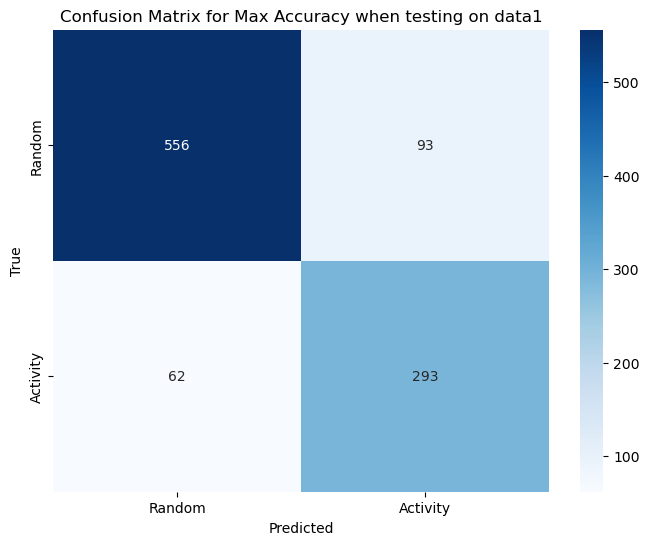

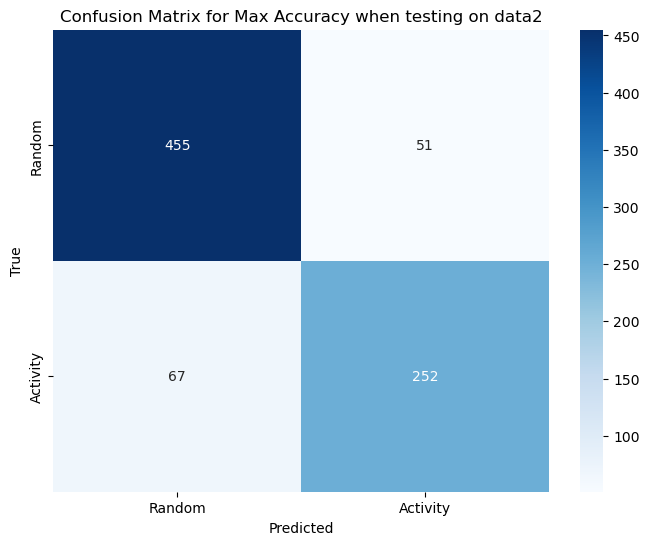

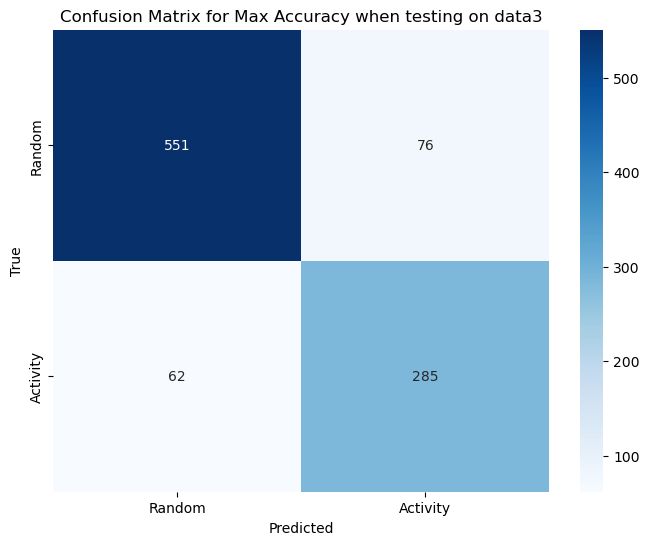

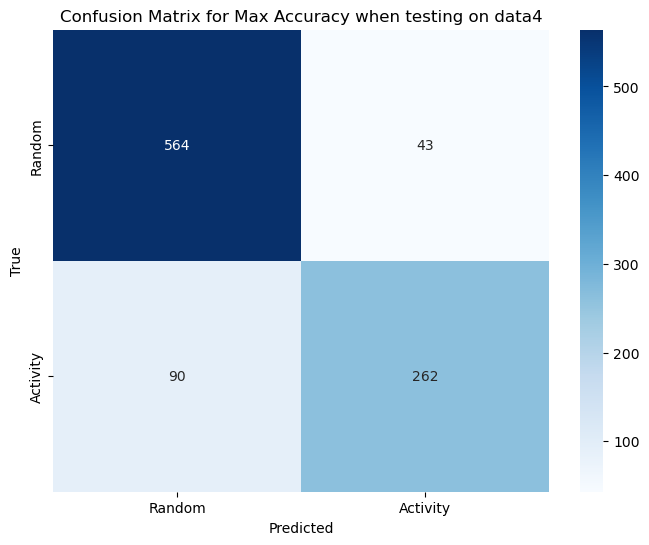

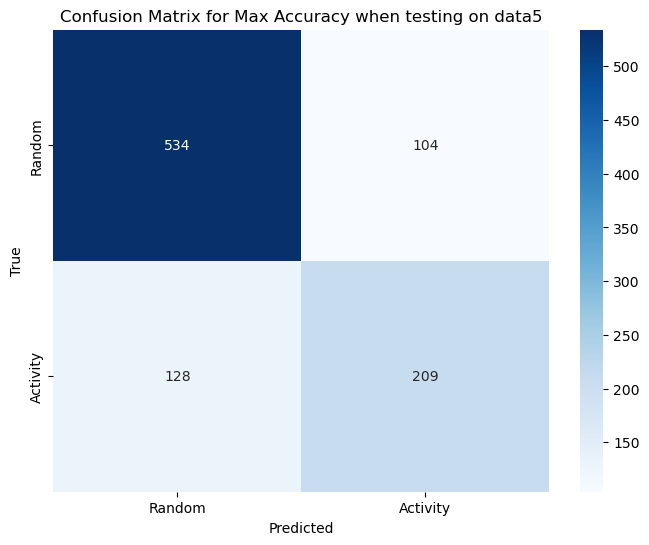

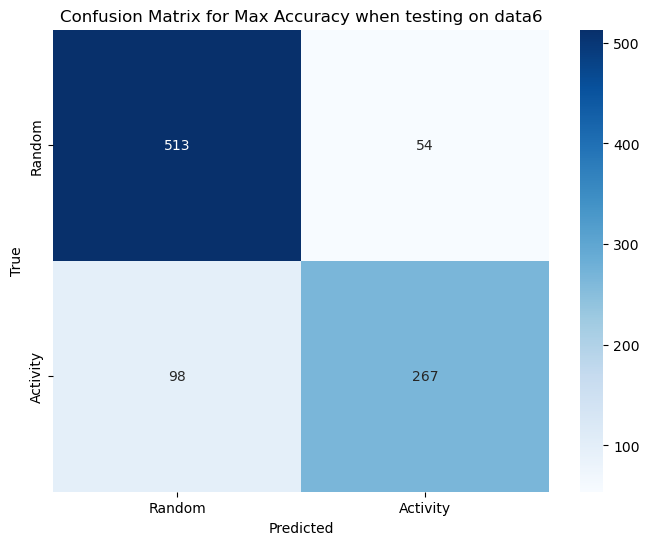

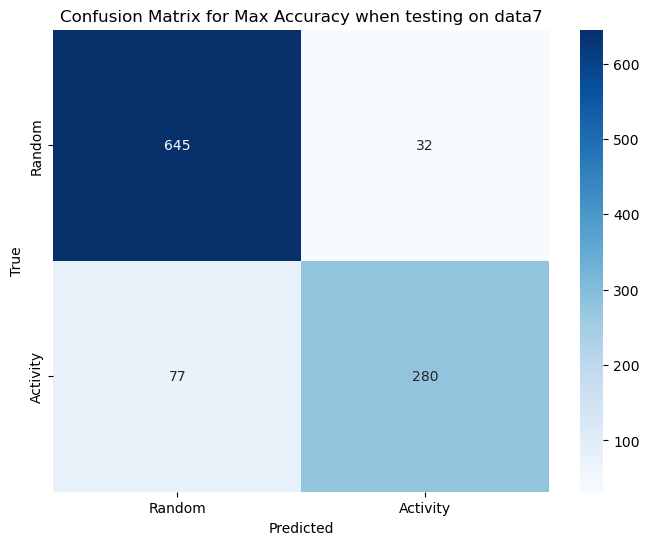

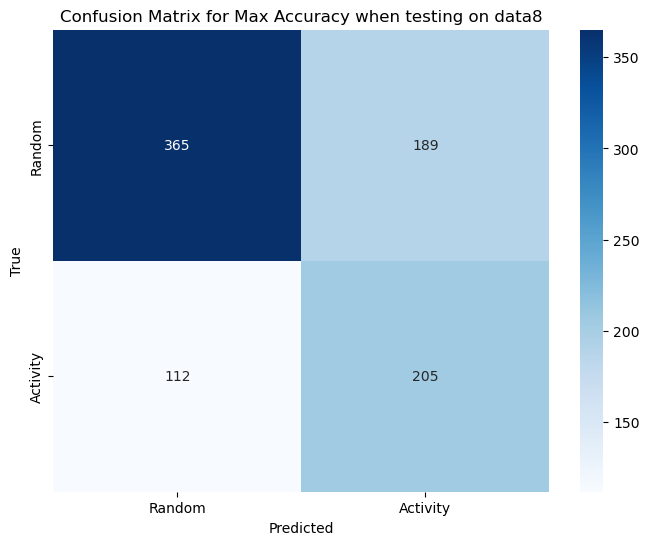

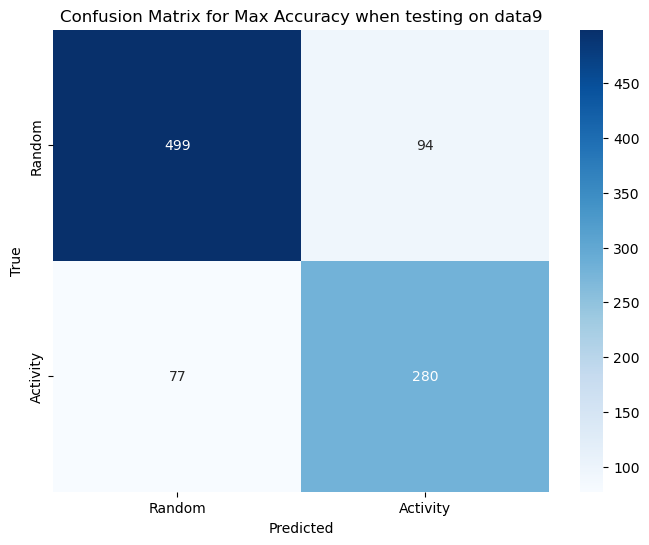

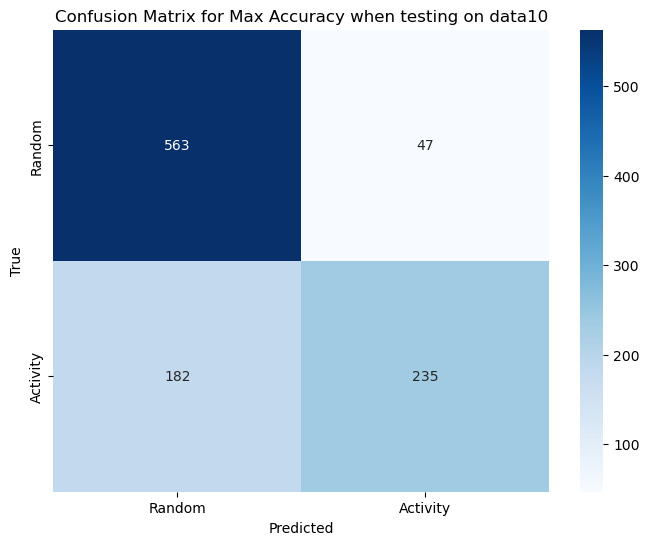

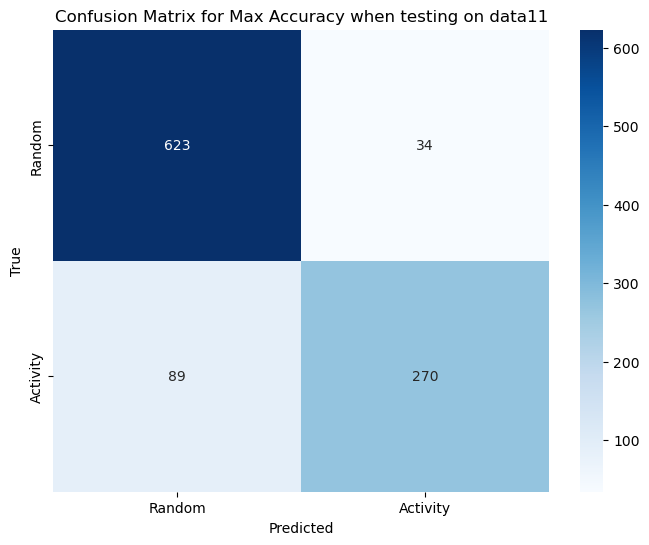

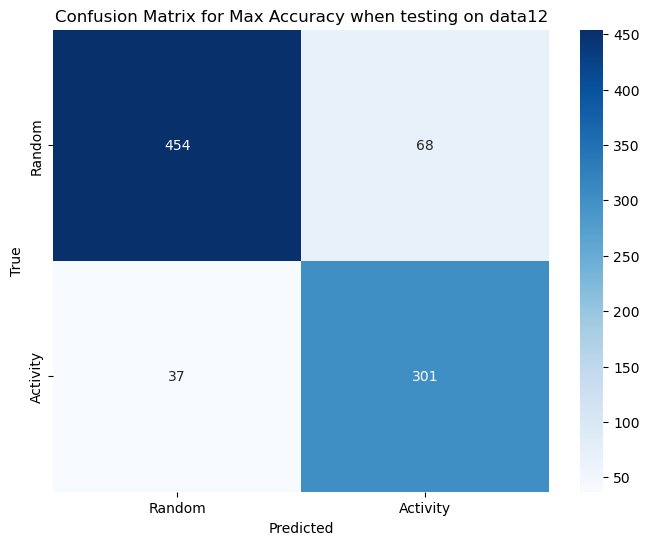

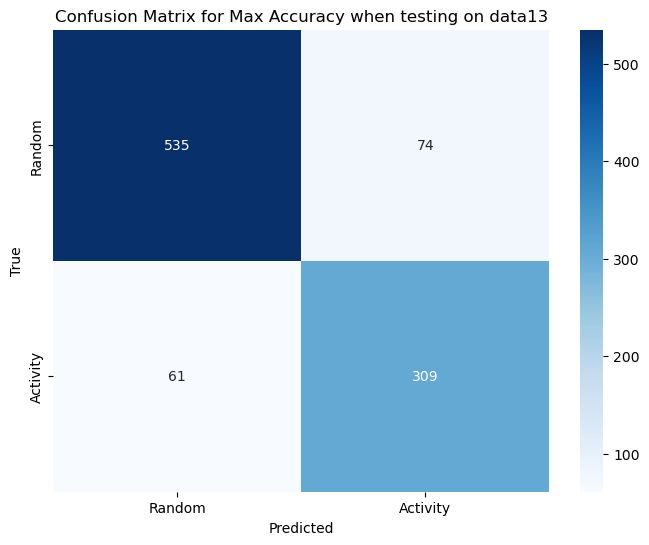

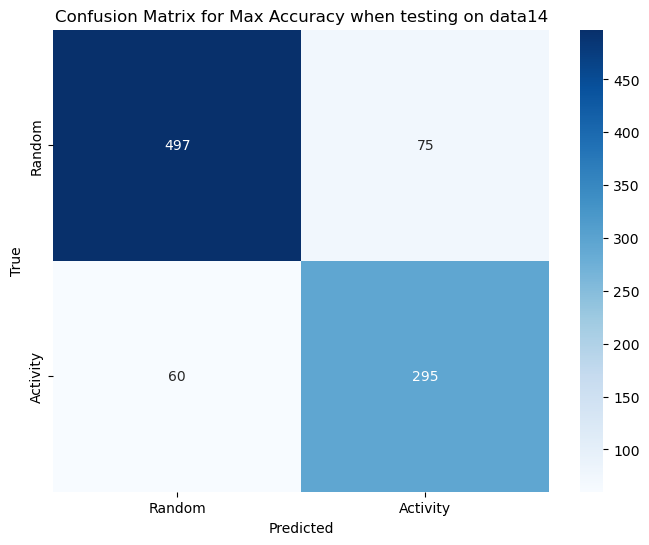

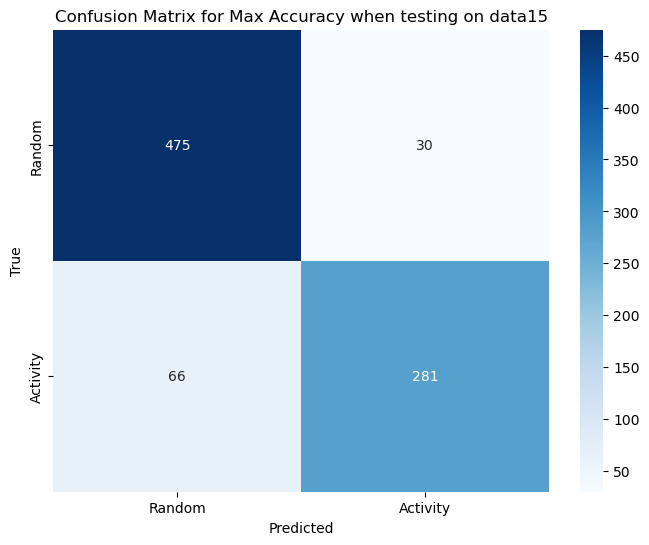

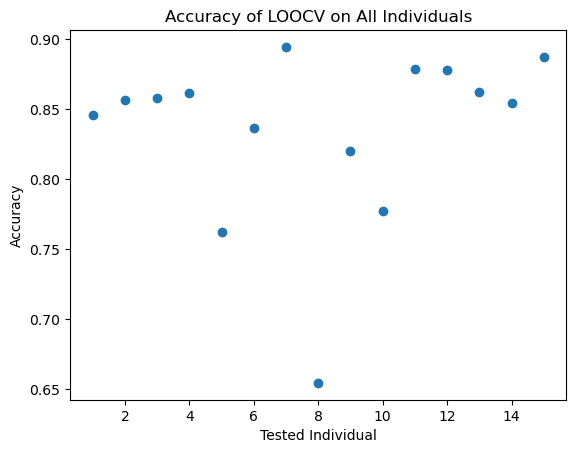

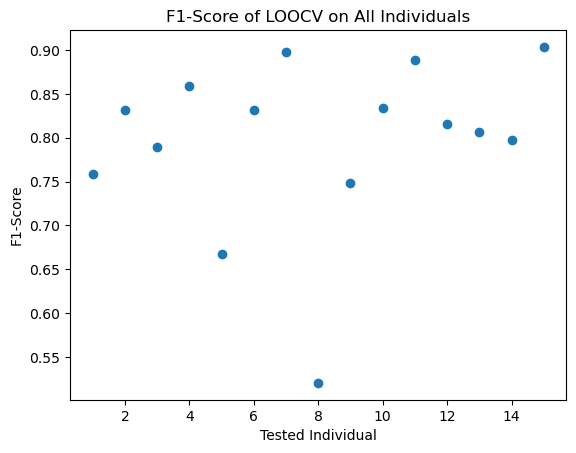

Average Accuracy:  0.8351896208414378
Average F1-Score:  0.7966655782112622


In [ ]:
## parameters C = 10; gamma = 0.1 for highest accuracy
LOOCVAccuracy = np.array([])
LOOCVf1_score = np.array([])

for tester in ppg_dataframes:
    trainingFeatures = [col for col in ppg_dataframes[tester].columns if col not in ["activity", "start_time", "end_time"]]

    testingFeatures = ppg_dataframes[tester][trainingFeatures].to_numpy()
    testingActivity = ppg_dataframes[tester]["activity"].to_numpy()

    X_train = pd.DataFrame()
    y_train = pd.DataFrame()
    for trainer in ppg_dataframes:
        if trainer != tester:
            X_train = pd.concat([X_train, ppg_dataframes[trainer][trainingFeatures]], ignore_index=True)
            y_train = pd.concat([y_train, ppg_dataframes[trainer]["activity"]], ignore_index=True)

    X_train = X_train.to_numpy()
    y_train = y_train.to_numpy().flatten()

    testingFeatures = StandardScaler().fit_transform(testingFeatures)
    X_train = StandardScaler().fit_transform(X_train)

    # Using best C and gamma for accuracy
    svm = SVC(C=10, gamma=0.1, kernel='rbf')
    svm.fit(X_train, y_train)

    y_pred = svm.predict(testingFeatures)
    cmat = confusion_matrix(testingActivity, y_pred)
    labels = ["Random", "Activity"]

    # Plot confusion matrix for accuracy
    plt.figure(figsize=(8, 6))
    sns.heatmap(cmat, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f"Confusion Matrix for Max Accuracy when testing on {tester}")
    plt.show()

    LOOCVAccuracy = np.append(LOOCVAccuracy, accuracy_score(testingActivity, y_pred))
    LOOCVf1_score = np.append(LOOCVf1_score, precision_score(testingActivity, y_pred, zero_division=0))

plt.scatter(np.arange(1,16), LOOCVAccuracy)
plt.title("Accuracy of LOOCV on All Individuals")
plt.xlabel("Tested Individual")
plt.ylabel("Accuracy")
plt.show()

plt.scatter(np.arange(1,16), LOOCVf1_score)
plt.title("F1-Score of LOOCV on All Individuals")
plt.xlabel("Tested Individual")
plt.ylabel("F1-Score")
plt.show()

print("Average Accuracy: ", sum(LOOCVAccuracy) / len(LOOCVAccuracy))
print("Average F1-Score: ", sum(LOOCVf1_score) / len(LOOCVf1_score))

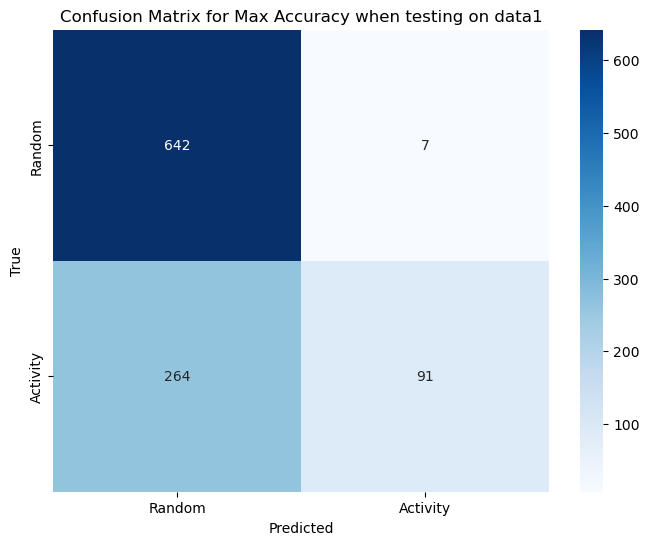

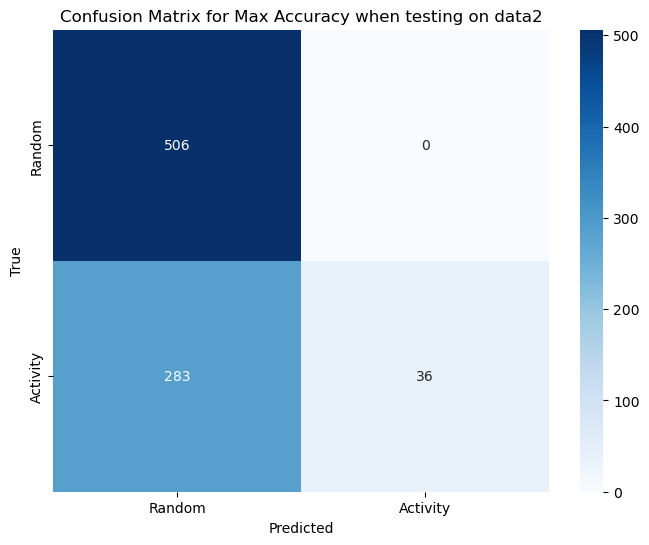

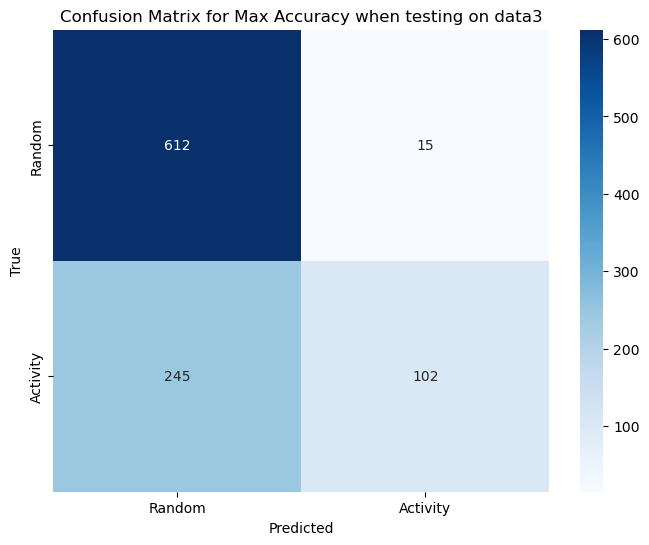

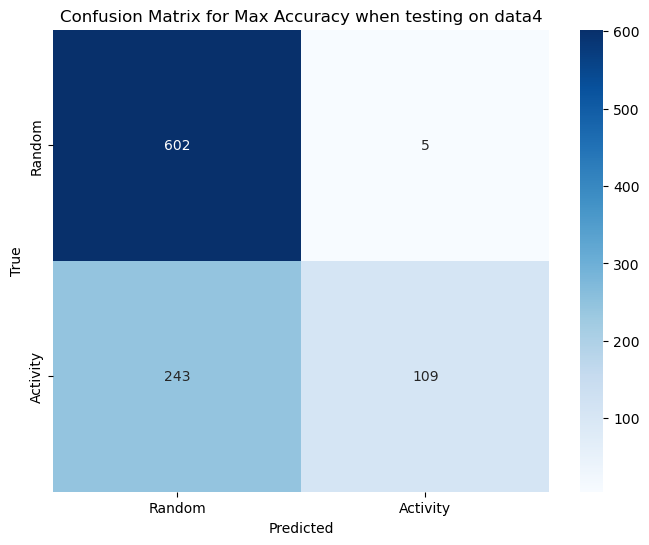

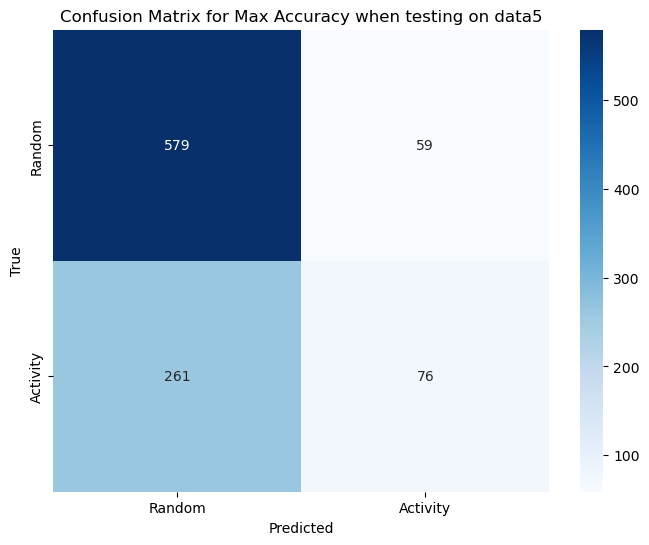

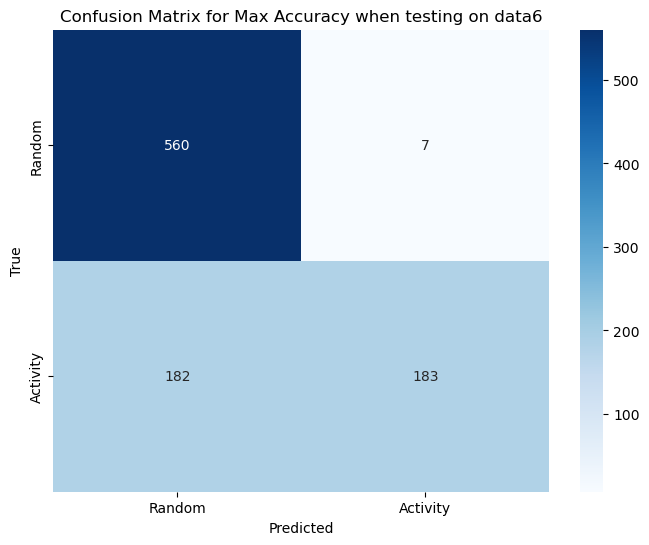

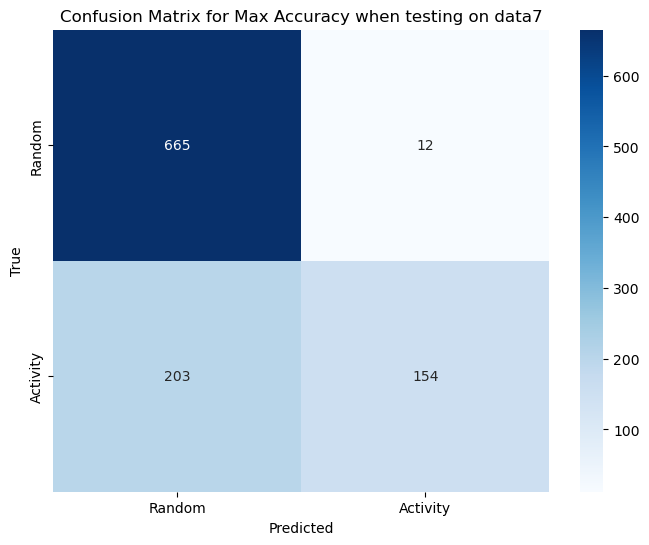

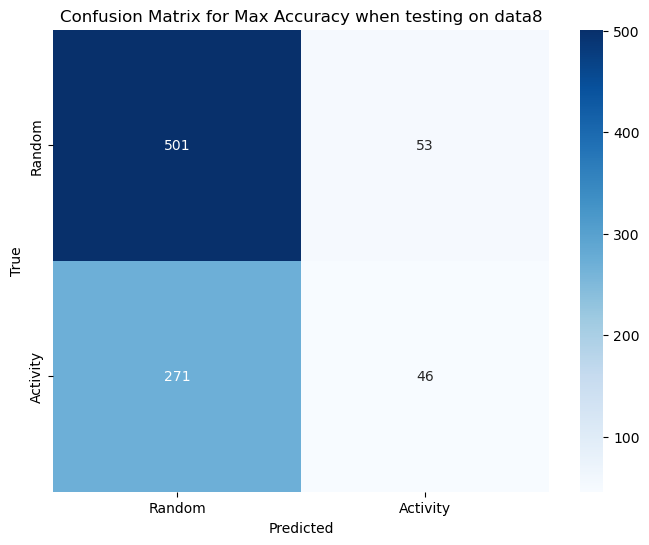

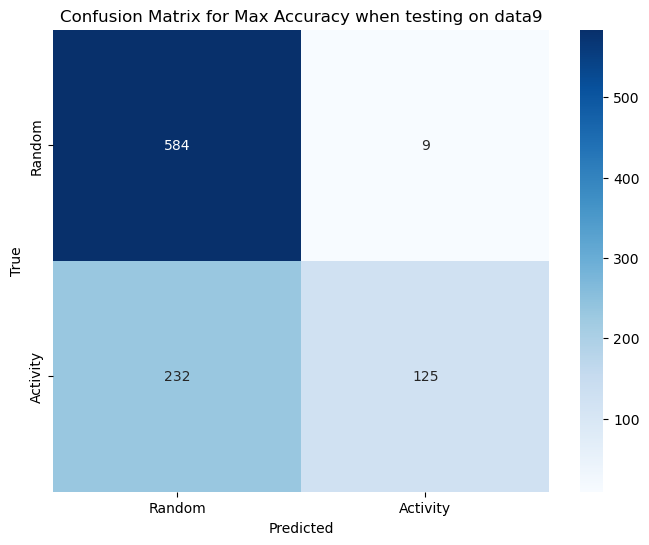

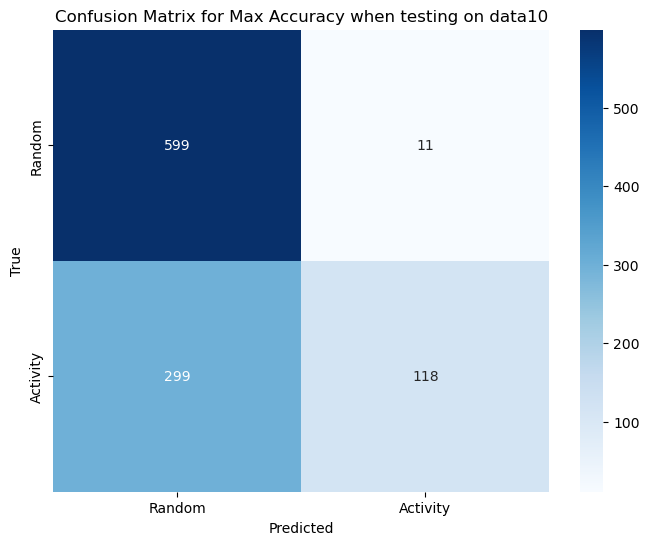

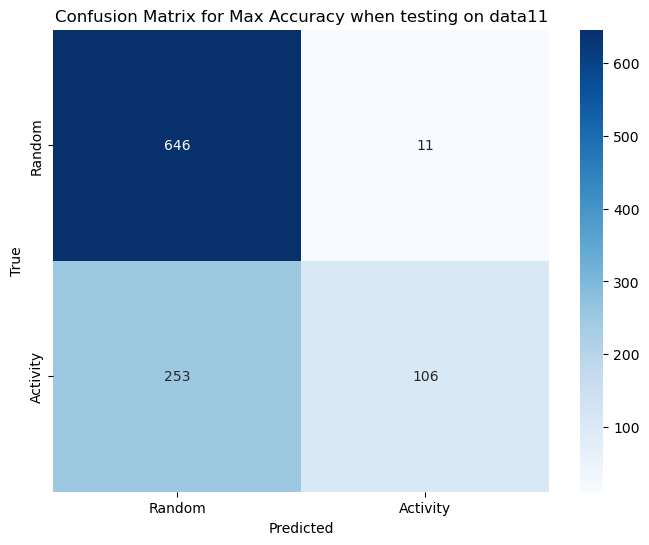

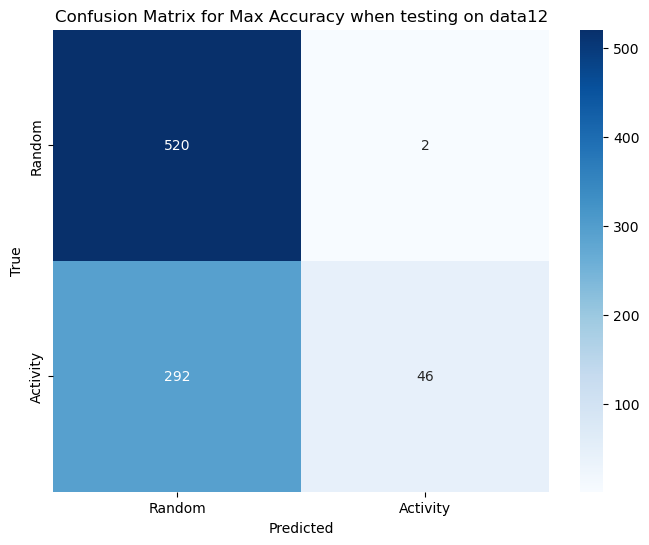

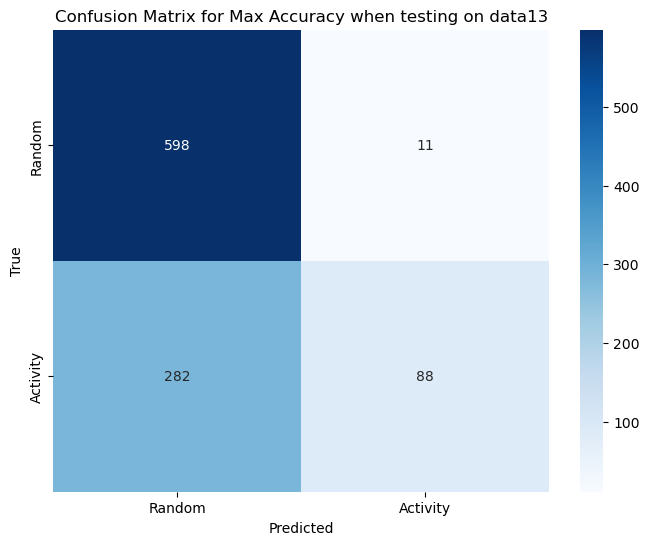

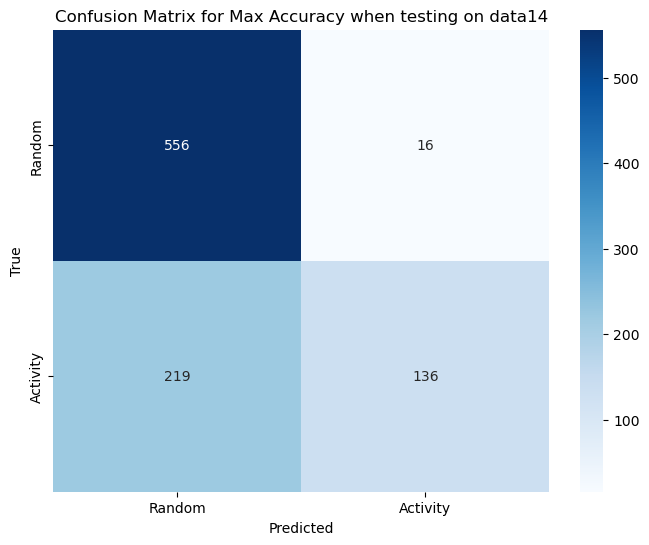

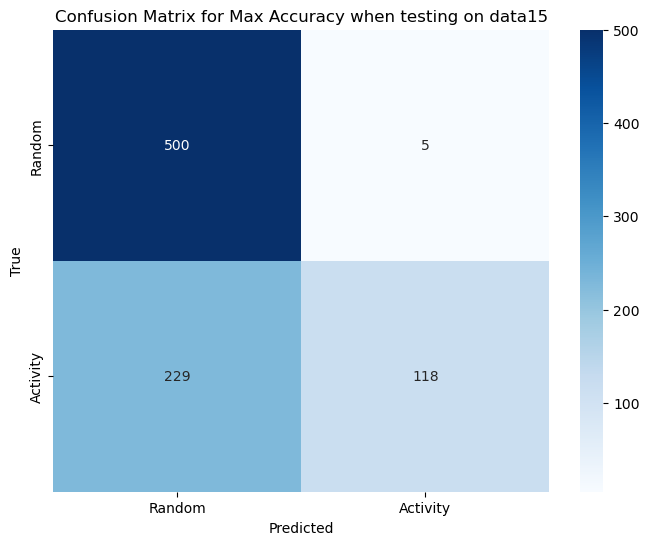

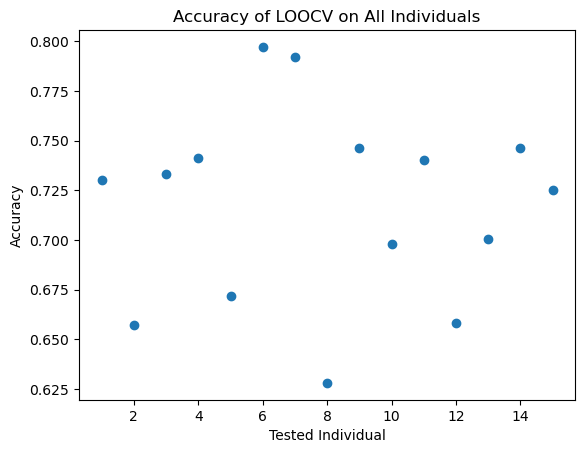

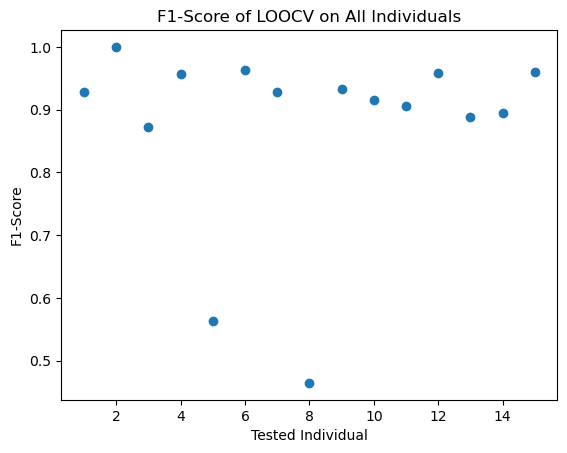

Average Accuracy:  0.7177279165463729
Average F1-Score:  0.8753227255890433


In [ ]:
## parameters C = 0.001; gamma = 0.1 for highest precision
LOOCVAccuracy = np.array([])
LOOCVf1_score = np.array([])

for tester in ppg_dataframes:
    trainingFeatures = [col for col in ppg_dataframes[tester].columns if col not in ["activity", "start_time", "end_time"]]

    testingFeatures = ppg_dataframes[tester][trainingFeatures].to_numpy()
    testingActivity = ppg_dataframes[tester]["activity"].to_numpy()

    X_train = pd.DataFrame()
    y_train = pd.DataFrame()
    for trainer in ppg_dataframes:
        if trainer != tester:
            X_train = pd.concat([X_train, ppg_dataframes[trainer][trainingFeatures]], ignore_index=True)
            y_train = pd.concat([y_train, ppg_dataframes[trainer]["activity"]], ignore_index=True)

    X_train = X_train.to_numpy()
    y_train = y_train.to_numpy().flatten()

    testingFeatures = StandardScaler().fit_transform(testingFeatures)
    X_train = StandardScaler().fit_transform(X_train)

    # Using best C and gamma for accuracy
    svm = SVC(C=0.001, gamma=0.1, kernel='rbf')
    svm.fit(X_train, y_train)

    y_pred = svm.predict(testingFeatures)
    cmat = confusion_matrix(testingActivity, y_pred)
    labels = ["Random", "Activity"]

    # Plot confusion matrix for accuracy
    plt.figure(figsize=(8, 6))
    sns.heatmap(cmat, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f"Confusion Matrix for Max Accuracy when testing on {tester}")
    plt.show()

    LOOCVAccuracy = np.append(LOOCVAccuracy, accuracy_score(testingActivity, y_pred))
    LOOCVf1_score = np.append(LOOCVf1_score, precision_score(testingActivity, y_pred, zero_division=0))

plt.scatter(np.arange(1,16), LOOCVAccuracy)
plt.title("Accuracy of LOOCV on All Individuals")
plt.xlabel("Tested Individual")
plt.ylabel("Accuracy")
plt.show()

plt.scatter(np.arange(1,16), LOOCVf1_score)
plt.title("F1-Score of LOOCV on All Individuals")
plt.xlabel("Tested Individual")
plt.ylabel("F1-Score")
plt.show()

print("Average Accuracy: ", sum(LOOCVAccuracy) / len(LOOCVAccuracy))
print("Average F1-Score: ", sum(LOOCVf1_score) / len(LOOCVf1_score))

In [ ]:
ppg_features = ppg_df_umap.drop(columns=['activity']).to_numpy()
ppg_activity = ppg_df_umap['activity'].to_numpy()

# Standardize the features
scaler = StandardScaler()
ppg_features_scaled = scaler.fit_transform(ppg_features)

# Train SVM on PPG data
svm_model = SVC(C=0.001, gamma=0.1, kernel='rbf')  # You can tune the kernel and other hyperparameters as needed
svm_model.fit(ppg_features_scaled, ppg_activity)

# Predict activity for each individual in the BigIdeas dataset
for key, df in bigideas_dataframes.items():
    bigideas_features = df.to_numpy()

    # Standardize the features using the same scaler
    bigideas_features_scaled = scaler.transform(bigideas_features)

    # Predict activity using the trained SVM model
    bigideas_activity = svm_model.predict(bigideas_features_scaled)

    # Add the predicted activity column to the BigIdeas DataFrame
    bigideas_dataframes[key]['activity'] = bigideas_activity

NameError: name 'SVCSVC' is not defined

In [ ]:
ppg_dataframes = {}
for i in np.arange(1, 16):
    name = f"data{i}"
    acc = pd.read_csv(f"HAR/ppg+dalia/data/PPG_FieldStudy/S{i}/S{i}_E4/ACC_specific_windowed_features.csv")
    hr = pd.read_csv(f"HAR/ppg+dalia/data/PPG_FieldStudy/S{i}/S{i}_E4/HR_specific_windowed_features.csv")
    bvp = pd.read_csv(f"HAR/ppg+dalia/data/PPG_FieldStudy/S{i}/S{i}_E4/BVP_specific_windowed_features.csv")
    acc['start_time'] = pd.to_datetime(acc['start_time'])
    hr['start_time'] = pd.to_datetime(hr['start_time'])
    bvp['start_time'] = pd.to_datetime(bvp['start_time'])
    acc['end_time'] = pd.to_datetime(acc['end_time'])
    hr['end_time'] = pd.to_datetime(hr['end_time'])
    bvp['end_time'] = pd.to_datetime(bvp['end_time'])

    common_columns = ['start_time', 'end_time', 'activity']
    data = acc.merge(hr, on=common_columns, how='inner').merge(bvp, on=common_columns, how='inner')
    allFeatures = [col for col in data.columns if col not in ["start_time", "end_time"]]
    data = data[allFeatures]
    data = data[~data['activity'].isin([0])]
    data.loc[data['activity'].isin([2, 7, 8, 9]), 'activity'] = 0
    data.loc[data['activity'].isin([3, 4, 5, 6]), 'activity'] = 1
    ppg_dataframes[name] = data

# Load and process BigIdeas dataframes
bigideas_dataframes = {}
for i in np.arange(1, 17):
    if i < 10:
        name = f"data{i}"
        acc = pd.read_csv(f"BigIdeas/00{i}/ACC_simple_windowed.csv")
        hr = pd.read_csv(f"BigIdeas/00{i}/HR_simple_windowed.csv")
        bvp = pd.read_csv(f"BigIdeas/00{i}/BVP_simple_windowed.csv")
    else:
        name = f"data{i}"
        acc = pd.read_csv(f"BigIdeas/0{i}/ACC_simple_windowed.csv")
        hr = pd.read_csv(f"BigIdeas/0{i}/HR_simple_windowed.csv")
        bvp = pd.read_csv(f"BigIdeas/0{i}/BVP_simple_windowed.csv")
    acc['start_time'] = pd.to_datetime(acc['start_time'])
    hr['start_time'] = pd.to_datetime(hr['start_time'])
    bvp['start_time'] = pd.to_datetime(bvp['start_time'])
    acc['end_time'] = pd.to_datetime(acc['end_time'])
    hr['end_time'] = pd.to_datetime(hr['end_time'])
    bvp['end_time'] = pd.to_datetime(bvp['end_time'])

    common_columns = ['start_time', 'end_time']
    data = acc.merge(hr, on=common_columns, how='inner').merge(bvp, on=common_columns, how='inner')
    allFeatures = [col for col in data.columns if col not in ["start_time", "end_time"]]
    data = data[allFeatures]
    data.columns = data.columns.str.replace(' ', '', regex=False)
    bigideas_dataframes[name] = data

ppg_combined_df = pd.concat([df.drop(columns=['activity']) for df in ppg_dataframes.values()], ignore_index=True)
bigideas_combined_df = pd.concat(bigideas_dataframes.values(), ignore_index=True)
combined_df = pd.concat([ppg_combined_df, bigideas_combined_df], ignore_index=True)

# Verify combined data shapes and columns
print("Shape of PPG Combined DataFrame (excluding 'activity'):", ppg_combined_df.shape)
print("Shape of BigIdeas Combined DataFrame:", bigideas_combined_df.shape)
print("Shape of Combined DataFrame:", combined_df.shape)
print("Columns in Combined DataFrame:", combined_df.columns)

# Ensure numerical columns are selected correctly
numerical_cols = [col for col in combined_df.columns if col != 'activity']
print("Numerical Columns:", numerical_cols)

# Check for NaNs
print("NaNs in Combined DataFrame:", combined_df[numerical_cols].isna().sum().sum())

# Standardize the features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(combined_df[numerical_cols])

# Compute UMAP
umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=3)
X_umap = umap_reducer.fit_transform(scaled_data)
umap_df = pd.DataFrame(data=X_umap, columns=[f'UMAP{i}' for i in np.arange(1, 4)])

# Create indices for splitting back the combined data
ppg_indices = list(range(len(ppg_combined_df)))
bigideas_indices = list(range(len(bigideas_combined_df)))

# Check index lengths
print("Length of UMAP DataFrame:", len(umap_df))
print("Length of PPG Indices:", len(ppg_indices))
print("Length of BigIdeas Indices:", len(bigideas_indices))

# Separate UMAP results back into original dataframes
ppg_df_umap = umap_df.iloc[ppg_indices].reset_index(drop=True)
bigideas_df_umap = umap_df.iloc[bigideas_indices].reset_index(drop=True)

# Add activity column back to ppg_df_umap
ppg_df_umap['activity'] = pd.concat([df[['activity']] for df in ppg_dataframes.values()], ignore_index=True).reset_index(drop=True)

# Update ppg_dataframes with UMAP data
start_idx = 0
for key, df in ppg_dataframes.items():
    end_idx = start_idx + len(df)
    ppg_dataframes[key] = ppg_df_umap.iloc[start_idx:end_idx].reset_index(drop=True)
    start_idx = end_idx

# Update bigideas_dataframes with UMAP data
start_idx = 0
for key, df in bigideas_dataframes.items():
    end_idx = start_idx + len(df)
    print(f"Updating BigIdeas DataFrame: {key}, Shape: {bigideas_df_umap.iloc[start_idx:end_idx].shape}")
    bigideas_dataframes[key] = bigideas_df_umap.iloc[start_idx:end_idx].reset_index(drop=True)
    start_idx = end_idx

# Check if any BigIdeas DataFrames are empty
empty_bigideas_dfs = {key: df for key, df in bigideas_dataframes.items() if df.empty}
if empty_bigideas_dfs:
    print("Empty BigIdeas DataFrames after UMAP:")
    for key in empty_bigideas_dfs:
        print(key)


Shape of PPG Combined DataFrame (excluding 'activity'): (14185, 70)
Shape of BigIdeas Combined DataFrame: (0, 70)
Shape of Combined DataFrame: (14185, 70)
Columns in Combined DataFrame: Index(['acc_x_mean', 'acc_x_min', 'acc_x_max', 'acc_x_median', 'acc_x_std',
       'acc_x_zcross', 'acc_x_meancross', 'fft_acc_x_mean', 'fft_acc_x_min',
       'fft_acc_x_second_max', 'fft_acc_x_dc_component', 'fft_acc_x_std',
       'fft_acc_x_median', 'fft_acc_x_dominant_freq', 'acc_y_mean',
       'acc_y_min', 'acc_y_max', 'acc_y_median', 'acc_y_std', 'acc_y_zcross',
       'acc_y_meancross', 'fft_acc_y_mean', 'fft_acc_y_min',
       'fft_acc_y_second_max', 'fft_acc_y_dc_component', 'fft_acc_y_std',
       'fft_acc_y_median', 'fft_acc_y_dominant_freq', 'acc_z_mean',
       'acc_z_min', 'acc_z_max', 'acc_z_median', 'acc_z_std', 'acc_z_zcross',
       'acc_z_meancross', 'fft_acc_z_mean', 'fft_acc_z_min',
       'fft_acc_z_second_max', 'fft_acc_z_dc_component', 'fft_acc_z_std',
       'fft_acc_z_median'

In [ ]:
bigideas_dataframes = {}
for i in np.arange(1, 17):
    if i < 10:
        name = f"data{i}"
        acc = pd.read_csv(f"BigIdeas/00{i}/ACC_simple_windowed.csv")
        hr = pd.read_csv(f"BigIdeas/00{i}/HR_simple_windowed.csv")
        bvp = pd.read_csv(f"BigIdeas/00{i}/BVP_simple_windowed.csv")
    else:
        name = f"data{i}"
        acc = pd.read_csv(f"BigIdeas/0{i}/ACC_simple_windowed.csv")
        hr = pd.read_csv(f"BigIdeas/0{i}/HR_simple_windowed.csv")
        bvp = pd.read_csv(f"BigIdeas/0{i}/BVP_simple_windowed.csv")

    acc['start_time'] = pd.to_datetime(acc['start_time'])
    hr['start_time'] = pd.to_datetime(hr['start_time'])
    bvp['start_time'] = pd.to_datetime(bvp['start_time'])
    acc['end_time'] = pd.to_datetime(acc['end_time'])
    hr['end_time'] = pd.to_datetime(hr['end_time'])
    bvp['end_time'] = pd.to_datetime(bvp['end_time'])

    print(f"Processing {name}...")
    print("ACC sample data:\n", acc.head())
    print("HR sample data:\n", hr.head())
    print("BVP sample data:\n", bvp.head())

    common_columns = ['start_time', 'end_time']
    try:
        data = acc.merge(hr, on=common_columns, how='inner').merge(bvp, on=common_columns, how='inner')
    except Exception as e:
        print(f"Error merging {name}: {e}")
        continue

    print(f"Merged data for {name}:")
    print(data.head(20))

    allFeatures  = [col for col in data.columns if col not in ["start_time", "end_time"]]
    data = data[allFeatures]
    data.columns = data.columns.str.replace(' ', '', regex=False)
    bigideas_dataframes[name] = data

print("Completed processing BigIdeas datasets.")

/tmp/ipykernel_1239167/1554913250.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  hr['start_time'] = pd.to_datetime(hr['start_time'])
/tmp/ipykernel_1239167/1554913250.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  hr['end_time'] = pd.to_datetime(hr['end_time'])


Processing data1...
ACC sample data:
            start_time            end_time   acc_x_mean   acc_x_min  \
0 2020-02-13 15:28:50 2020-02-13 15:28:57   -22.675556       -60.0   
1 2020-02-13 15:28:57 2020-02-13 15:29:04    -2.826667       -40.0   
2 2020-02-13 15:29:04 2020-02-13 15:29:11    -2.217778       -71.0   
3 2020-02-13 15:29:11 2020-02-13 15:29:18   -14.488889       -75.0   
4 2020-02-13 15:29:18 2020-02-13 15:29:25    57.506667        30.0   

    acc_x_max   acc_x_median   acc_x_std   acc_x_zcross   acc_x_meancross  \
0         8.0          -27.0   16.296269       0.129464          0.044643   
1        62.0           -1.0   17.592643       0.151786          0.129464   
2        59.0            0.0   23.484258       0.191964          0.165179   
3        55.0          -16.0   26.753356       0.071429          0.089286   
4       103.0           58.0    7.221075       0.000000          0.397321   

   fft_ acc_x_mean  ...   acc_z_std   acc_z_zcross   acc_z_meancross  \
0     

Processing data3...
ACC sample data:
            start_time            end_time   acc_x_mean   acc_x_min  \
0 2020-02-22 18:09:41 2020-02-22 18:09:48   -60.960000       -65.0   
1 2020-02-22 18:09:48 2020-02-22 18:09:55   -61.333333       -65.0   
2 2020-02-22 18:09:55 2020-02-22 18:10:02   -64.533333       -82.0   
3 2020-02-22 18:10:02 2020-02-22 18:10:09   -63.866667       -76.0   
4 2020-02-22 18:10:09 2020-02-22 18:10:16   -64.146667       -77.0   

    acc_x_max   acc_x_median   acc_x_std   acc_x_zcross   acc_x_meancross  \
0       -57.0          -61.0    1.286329            0.0          0.330357   
1       -56.0          -61.0    1.863656            0.0          0.209821   
2       -38.0          -65.0    5.704791            0.0          0.227679   
3       -44.0          -64.0    5.217587            0.0          0.111607   
4       -48.0          -64.0    2.087548            0.0          0.366071   

   fft_ acc_x_mean  ...   acc_z_std   acc_z_zcross   acc_z_meancross  \
0     

Processing data5...
ACC sample data:
            start_time            end_time   acc_x_mean   acc_x_min  \
0 2020-02-27 13:34:02 2020-02-27 13:34:09     7.417778       -50.0   
1 2020-02-27 13:34:09 2020-02-27 13:34:16    -3.266667       -73.0   
2 2020-02-27 13:34:16 2020-02-27 13:34:23   -22.702222       -96.0   
3 2020-02-27 13:34:23 2020-02-27 13:34:30   -56.551111       -67.0   
4 2020-02-27 13:34:30 2020-02-27 13:34:37   -52.240000       -86.0   

    acc_x_max   acc_x_median   acc_x_std   acc_x_zcross   acc_x_meancross  \
0        38.0           12.0   14.640747       0.044643          0.098214   
1        63.0           -5.0   19.944342       0.138393          0.125000   
2        67.0          -40.0   36.493948       0.071429          0.049107   
3       -50.0          -56.0    2.809155       0.000000          0.160714   
4         5.0          -56.0   13.161266       0.008929          0.263393   

   fft_ acc_x_mean  ...   acc_z_std   acc_z_zcross   acc_z_meancross  \
0     

Processing data7...
ACC sample data:
            start_time            end_time   acc_x_mean   acc_x_min  \
0 2020-03-14 10:24:28 2020-03-14 10:24:35     6.151111       -40.0   
1 2020-03-14 10:24:35 2020-03-14 10:24:42   -11.928889       -48.0   
2 2020-03-14 10:24:42 2020-03-14 10:24:49   -12.675556       -47.0   
3 2020-03-14 10:24:49 2020-03-14 10:24:56    -9.653333       -36.0   
4 2020-03-14 10:24:56 2020-03-14 10:25:03    -9.675556       -29.0   

    acc_x_max   acc_x_median   acc_x_std   acc_x_zcross   acc_x_meancross  \
0        61.0           -2.0   28.559060       0.058036          0.031250   
1        70.0          -15.0   15.899357       0.080357          0.102679   
2        14.0          -11.0    9.517680       0.017857          0.102679   
3        25.0          -10.0   18.746066       0.026786          0.040179   
4         6.0          -10.0    3.216389       0.017857          0.142857   

   fft_ acc_x_mean  ...   acc_z_std   acc_z_zcross   acc_z_meancross  \
0     

Processing data9...
ACC sample data:
            start_time            end_time   acc_x_mean   acc_x_min  \
0 2020-03-21 08:41:26 2020-03-21 08:41:33   -25.217778       -72.0   
1 2020-03-21 08:41:33 2020-03-21 08:41:40   -42.657778       -97.0   
2 2020-03-21 08:41:40 2020-03-21 08:41:47    -6.577778       -46.0   
3 2020-03-21 08:41:47 2020-03-21 08:41:54     3.715556       -89.0   
4 2020-03-21 08:41:54 2020-03-21 08:42:01    24.906667       -61.0   

    acc_x_max   acc_x_median   acc_x_std   acc_x_zcross   acc_x_meancross  \
0        27.0          -19.0   18.825364       0.062500          0.107143   
1        -4.0          -44.0   17.183444       0.000000          0.133929   
2        57.0          -11.0   22.053191       0.120536          0.129464   
3        66.0           10.0   40.346590       0.053571          0.040179   
4        60.0           30.0   25.042913       0.102679          0.035714   

   fft_ acc_x_mean  ...   acc_z_std   acc_z_zcross   acc_z_meancross  \
0     

Processing data11...
ACC sample data:
            start_time            end_time   acc_x_mean   acc_x_min  \
0 2020-04-06 08:24:55 2020-04-06 08:25:02    -1.146667       -21.0   
1 2020-04-06 08:25:02 2020-04-06 08:25:09    -1.493333       -22.0   
2 2020-04-06 08:25:09 2020-04-06 08:25:16    -2.902222        -3.0   
3 2020-04-06 08:25:16 2020-04-06 08:25:23    -0.826667       -58.0   
4 2020-04-06 08:25:23 2020-04-06 08:25:30    -1.337778        -4.0   

    acc_x_max   acc_x_median   acc_x_std   acc_x_zcross   acc_x_meancross  \
0        21.0           -1.0    3.405720       0.058036          0.120536   
1        39.0           -3.0    6.097511       0.084821          0.111607   
2        -2.0           -3.0    0.297676       0.000000          0.174107   
3        80.0           -3.0   16.535978       0.165179          0.174107   
4         3.0           -1.0    0.669251       0.004464          0.500000   

   fft_ acc_x_mean  ...   acc_z_std   acc_z_zcross   acc_z_meancross  \
0    

Processing data13...
ACC sample data:
            start_time            end_time   acc_x_mean   acc_x_min  \
0 2020-05-28 13:58:58 2020-05-28 13:59:05   -32.235556       -94.0   
1 2020-05-28 13:59:05 2020-05-28 13:59:12   -20.613333       -71.0   
2 2020-05-28 13:59:12 2020-05-28 13:59:19    23.177778       -16.0   
3 2020-05-28 13:59:19 2020-05-28 13:59:26    12.404444      -128.0   
4 2020-05-28 13:59:26 2020-05-28 13:59:33   -37.715556      -100.0   

    acc_x_max   acc_x_median   acc_x_std   acc_x_zcross   acc_x_meancross  \
0        98.0          -32.0   24.291617       0.075893          0.116071   
1        21.0          -22.0   19.621117       0.138393          0.129464   
2        65.0           23.0   19.854256       0.087054          0.062500   
3        54.0           23.0   32.665116       0.024554          0.026786   
4        20.0          -38.0   17.306816       0.022321          0.183036   

   fft_ acc_x_mean  ...   acc_z_std   acc_z_zcross   acc_z_meancross  \
0    

Processing data15...
ACC sample data:
            start_time            end_time  acc_x_mean  acc_x_min  acc_x_max  \
0 2020-07-24 07:07:49 2020-07-24 07:07:56  -37.524444      -94.0        2.0   
1 2020-07-24 07:07:56 2020-07-24 07:08:03  -23.164444      -90.0       74.0   
2 2020-07-24 07:08:03 2020-07-24 07:08:10   30.355556       16.0       82.0   
3 2020-07-24 07:08:10 2020-07-24 07:08:17   25.915556       14.0       36.0   
4 2020-07-24 07:08:17 2020-07-24 07:08:24   53.408889       29.0       74.0   

   acc_x_median  acc_x_std  acc_x_zcross  acc_x_meancross  fft_acc_x_mean  \
0         -41.0  25.718090      0.026786         0.058036      211.143088   
1         -23.0  29.114070      0.013393         0.022321      257.220331   
2          24.0  13.403683      0.000000         0.031250      124.616946   
3          26.0   5.018446      0.000000         0.111607       66.574350   
4          56.0   9.431705      0.000000         0.062500      126.923190   

   ...  acc_z_std  acc_

In [ ]:
data1_path = 'BigIdeas/001/HR_simple_windowed.csv'
data1_df = pd.read_csv(data1_path)

# Convert 'start_time' and 'end_time' to datetime (with correct format)
data1_df['start_time'] = pd.to_datetime(data1_df['start_time'], format='%m/%d/%y %H:%M')
data1_df['end_time'] = pd.to_datetime(data1_df['end_time'], format='%m/%d/%y %H:%M')

# Define the time delta for the intervals
time_delta = pd.Timedelta(seconds=7)

# Create lists for the new start and end times
new_start_times = []
new_end_times = []

# Adjust the start and end times
for i in range(len(data1_df)):
    # Extract the base date, hour, and minute from the first record
    base_start_time = data1_df['start_time'].iloc[0]

    # Compute the new start and end times
    new_start_time = base_start_time + pd.Timedelta(seconds=i * 7)
    new_end_time = new_start_time + pd.Timedelta(seconds=7)

    # Append to lists
    new_start_times.append(new_start_time)
    new_end_times.append(new_end_time)

# Update the DataFrame
data1_df['start_time'] = new_start_times
data1_df['end_time'] = new_end_times

# Save the updated DataFrame back to CSV (if needed)
data1_df.to_csv(data1_path, index=False)

print("Updated start and end times for data1.")

ValueError: time data "2020-02-13 15:29:00" doesn't match format "%m/%d/%y %H:%M", at position 0. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [ ]:
hr_file = "BigIdeas/001/HR_001.csv"
hr_df = pd.read_csv(hr_file)

# Convert 'datetime' column to datetime type with the correct format
hr_df['datetime'] = pd.to_datetime(hr_df['datetime'], format='%m/%d/%y %H:%M')

# Start from the first datetime value
start_time = hr_df['datetime'].iloc[0]

# Add seconds to the datetime column starting from 00 and incrementing by 1 for each row
hr_df['datetime'] = [start_time + pd.Timedelta(seconds=i) for i in range(len(hr_df))]

# Resave the HR data with updated datetime
hr_df.to_csv(hr_file, index=False)
print(f"Updated {hr_file} with seconds included in datetime.")

Updated BigIdeas/001/HR_001.csv with seconds included in datetime.


In [ ]:
import numpy as np
import pandas as pd

for i in np.arange(14, 17):
    if i < 10:
        name = f"data{i}"
        acc = pd.read_csv(f"BigIdeas/00{i}/ACC_00{i}_simple_windowed.csv")
        hr = pd.read_csv(f"BigIdeas/00{i}/HR_00{i}_simple_windowed.csv")
        bvp = pd.read_csv(f"BigIdeas/00{i}/BVP_00{i}_simple_windowed.csv")
    if i > 9:
        name = f"data{i}"
        acc = pd.read_csv(f"BigIdeas/0{i}/ACC_0{i}_simple_windowed.csv")
        hr = pd.read_csv(f"BigIdeas/0{i}/HR_0{i}_simple_windowed.csv")
        bvp = pd.read_csv(f"BigIdeas/0{i}/BVP_0{i}_simple_windowed.csv")
    acc['start_time'] = pd.to_datetime(acc['start_time'])
    hr['start_time'] = pd.to_datetime(hr['start_time'])
    bvp['start_time'] = pd.to_datetime(bvp['start_time'])
    acc['end_time'] = pd.to_datetime(acc['end_time'])
    hr['end_time'] = pd.to_datetime(hr['end_time'])
    bvp['end_time'] = pd.to_datetime(bvp['end_time'])

    common_columns = ['start_time', 'end_time']
    data = acc.merge(hr, on=common_columns, how='inner').merge(bvp, on=common_columns, how='inner')
    print(len(data))
    print(len(acc))
    print(len(hr))
    print(len(bvp))

23166
23166
23166
23166
14375
14375
14375
14375
79729
79729
79729
79729
